## Importing and prepping data

In [2]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca
import os

In [23]:
features = []
remote_folder = 'Gel_studies' #Folder in AWS S3 containing files to be analyzed
bucket = 'dtoghani.data'
vids = 10
mws = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Calcium Concentration', 'Deff2',
          'Mean Mean_Intensity', 'Std Mean_Intensity']
calcs = [3]

counter = 0
for calc in calcs:
    for mw in mws:
        for num in range(1, vids+1):
            try:
                filename = 'features_{}_{}mM_XY{}.csv'.format(mw, calc, '%02d' % num)
                os.remove(filename)
                aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
                fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
                fstats['Particle Type'] = pd.Series(fstats.shape[0]*[mw], index=fstats.index)
                fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
                #fstats['Calcium Concentration'] = pd.Series(fstats.shape[0]*[str(calcs)], index=fstats.index)
                #print(num)
                print(filename)
                counter = counter + 1
                if counter == 1:
                    fstats_tot = fstats
                else:
                    fstats_tot = fstats_tot.append(fstats, ignore_index=True)
            except:
                print('skip filename: {}'.format(filename))

features_10k_PEG_3mM_XY01.csv
features_10k_PEG_3mM_XY02.csv
features_10k_PEG_3mM_XY03.csv
features_10k_PEG_3mM_XY04.csv
skip filename: features_10k_PEG_3mM_XY05.csv
features_10k_PEG_3mM_XY06.csv
features_10k_PEG_3mM_XY07.csv
skip filename: features_10k_PEG_3mM_XY08.csv
features_10k_PEG_3mM_XY09.csv
features_10k_PEG_3mM_XY10.csv
features_5k_PEG_3mM_XY01.csv
features_5k_PEG_3mM_XY02.csv
features_5k_PEG_3mM_XY03.csv
features_5k_PEG_3mM_XY04.csv
features_5k_PEG_3mM_XY05.csv
features_5k_PEG_3mM_XY06.csv
features_5k_PEG_3mM_XY07.csv
features_5k_PEG_3mM_XY08.csv
features_5k_PEG_3mM_XY09.csv
features_5k_PEG_3mM_XY10.csv
features_1k_PEG_3mM_XY01.csv
features_1k_PEG_3mM_XY02.csv
skip filename: features_1k_PEG_3mM_XY03.csv
features_1k_PEG_3mM_XY04.csv
features_1k_PEG_3mM_XY05.csv
features_1k_PEG_3mM_XY06.csv
features_1k_PEG_3mM_XY07.csv
features_1k_PEG_3mM_XY08.csv
skip filename: features_1k_PEG_3mM_XY09.csv
features_1k_PEG_3mM_XY10.csv
features_PS_COOH_3mM_XY01.csv
features_PS_COOH_3mM_XY02.csv


In [ ]:
fstats_new.to_csv('features.csv')

In [ ]:
fstats_tot.shape

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_new.shape[0]), 500000)))
fstats_sub = fstats_new.loc[subset, :].reset_index(drop=True)

In [24]:
#with equal sample sizes for each particle type
import random
counter = 0
#mws = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
for mw in mws:
    fstats_type = fstats_tot[fstats_tot['Particle Type']==mw].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 18000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(512864, 69)
(437414, 69)
(394035, 69)
(18610, 69)


In [ ]:
for mw in mws:
    print(fstats_new[fstats_tot['Particle Type'] == mw].shape)

In [ ]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
fstats_totMW = fstats_sub[fstats_sub['Particle Type'].isin(['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH'])].reset_index(drop=True)
#nonnum = ['Particle Type', 'Video Number', 'Track_ID', 'Calcium Concentration', 'Deff2']
fstats_num = fstats_totMW.drop(nonnum, axis=1)
fstats_raw = fstats_num.values
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [ ]:
pcadataset = pca.pca_analysis(fstats_totMW, dropcols=nonnum, n_components=11)

The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [10]:
kmostat = pca.kmo(pcadataset.scaled)

0.932854226596


## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [11]:
import numpy as np
ncomp = 11
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='10k_PEG'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='5k_PEG'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='1k_PEG'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final['Particle Type']=='PS_COOH'].values[:, -ncomp:], axis=0)

In [ ]:
dicti[3]

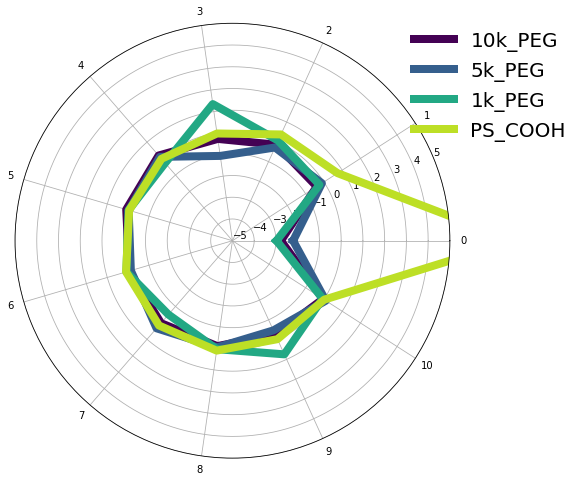

In [15]:
labels = ['10k_PEG', '5k_PEG', '1k_PEG', 'PS_COOH']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-5, 5, 11))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

In [16]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10
0,Std trappedness,Std asymmetry1,asymmetry3,Mean Y,straightness,Mean frames,MSD_ratio,D_fit,kurtosis,Std D_fit,Std Y
1,Std fractal_dim,Mean AR,AR,X,elongation,frames,Mean MSD_ratio,alpha,Std frames,D_fit,Std D_fit
2,Mean trappedness,Std kurtosis,asymmetry2,Mean X,fractal_dim,Mean D_fit,frames,efficiency,Mean D_fit,Mean D_fit,fractal_dim
3,SN_Ratio,Mean fractal_dim,asymmetry1,Quality,Mean straightness,straightness,Mean frames,trappedness,Std D_fit,Std efficiency,elongation
4,Mean Quality,Mean elongation,trappedness,Y,Mean D_fit,elongation,elongation,straightness,Std MSD_ratio,Std X,efficiency


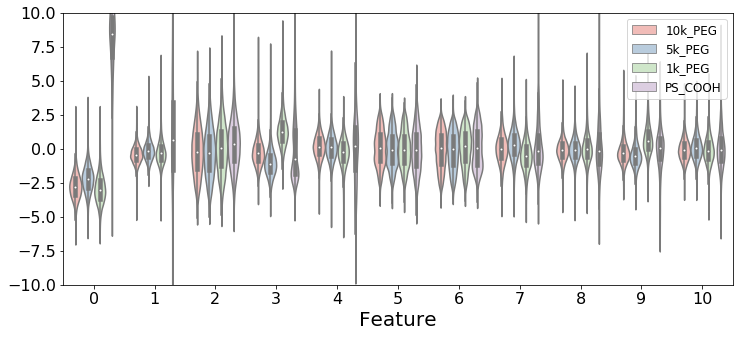

In [18]:
feats = pca.feature_violin(pcadataset.final, label='Particle Type', lvals=labels, fsubset=11, yrange=[-10, 10])

In [ ]:
fstats1 = pca.feature_plot_2D(pcadataset.final, label='Particle Type', lvals=labels, randcount=400, yrange=[-6, 6],
                              xrange=[-4, 4])

In [ ]:
dataset = pcadataset.final
dataset[dataset['Particle Type'] == 'PS_COOH']

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import random

def feature_plot_3D(dataset, label, features=[0, 1, 2], lvals=['PEG', 'PS'], randsel=True,
                    randcount=200, **kwargs):

    defaults = {'figsize': (8, 8), 'dotsize': 70, 'alpha': 0.7, 'xlim': None,
                'ylim': None, 'zlim': None, 'legendfontsize': 12,
                'labelfontsize': 10, 'fname': None}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]

    axes = {}
    fig = plt.figure(figsize=(14, 14))
    axes[1] = fig.add_subplot(221, projection='3d')
    axes[2] = fig.add_subplot(222, projection='3d')
    axes[3] = fig.add_subplot(223, projection='3d')
    axes[4] = fig.add_subplot(224, projection='3d')
    color = iter(cm.viridis(np.linspace(0, 0.9, 3)))
    angle1 = [60, 0, 0, 0]
    angle2 = [240, 240, 10, 190]

    tgroups = {}
    xy = {}
    counter = 0
    #labels = dataset[label].unique()
    for lval in lvals:
        tgroups[counter] = dataset[dataset[label] == lval]
        #print(lval)
        #print(tgroups[counter].shape)
        counter = counter + 1

    N = len(tgroups)
    color = iter(cm.viridis(np.linspace(0, 0.9, N)))

    counter = 0
    for key in tgroups:
        c = next(color)
        xy = []
        if randsel:
            #print(range(0, len(tgroups[key][0].tolist())))
            to_plot = random.sample(range(0, len(tgroups[key][0].tolist())),
                                    randcount)
            for key2 in features:
                xy.append(list(tgroups[key][key2].tolist()[i] for i in to_plot))
        else:
            for key2 in features:
                xy.append(tgroups[key][key2])

        acount = 0
        for ax in axes:
            axes[ax].scatter(xy[0], xy[1], xy[2], c=c, s=kwargs['dotsize'], alpha=kwargs['alpha'], label=labels[counter])
            if kwargs['xlim'] is not None:
                axes[ax].set_xlim3d(kwargs['xlim'][0], kwargs['xlim'][1])
            if kwargs['ylim'] is not None:
                axes[ax].set_ylim3d(kwargs['ylim'][0], kwargs['ylim'][1])
            if kwargs['zlim'] is not None:
                axes[ax].set_zlim3d(kwargs['zlim'][0], kwargs['zlim'][1])
            axes[ax].view_init(angle1[acount], angle2[acount])
            axes[ax].set_xlabel('Prin. Component {}'.format(features[0]),
                                fontsize=kwargs['labelfontsize'])
            axes[ax].set_ylabel('Prin. Component {}'.format(features[1]),
                                fontsize=kwargs['labelfontsize'])
            axes[ax].set_zlabel('Prin. Component {}'.format(features[2]),
                                fontsize=kwargs['labelfontsize'])
            acount = acount + 1
        counter = counter + 1

    # plt.legend(fontsize=kwargs['legendfontsize'], frameon=False)
    axes[3].set_xticks([])
    axes[4].set_xticks([])

    if kwargs['fname'] is None:
        plt.show()
    else:
        plt.savefig(kwargs['fname'])

In [ ]:
fstats1 = feature_plot_3D(pcadataset.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-20, 20],
                              xlim=[-20, 20], zlim=[-20, 20])

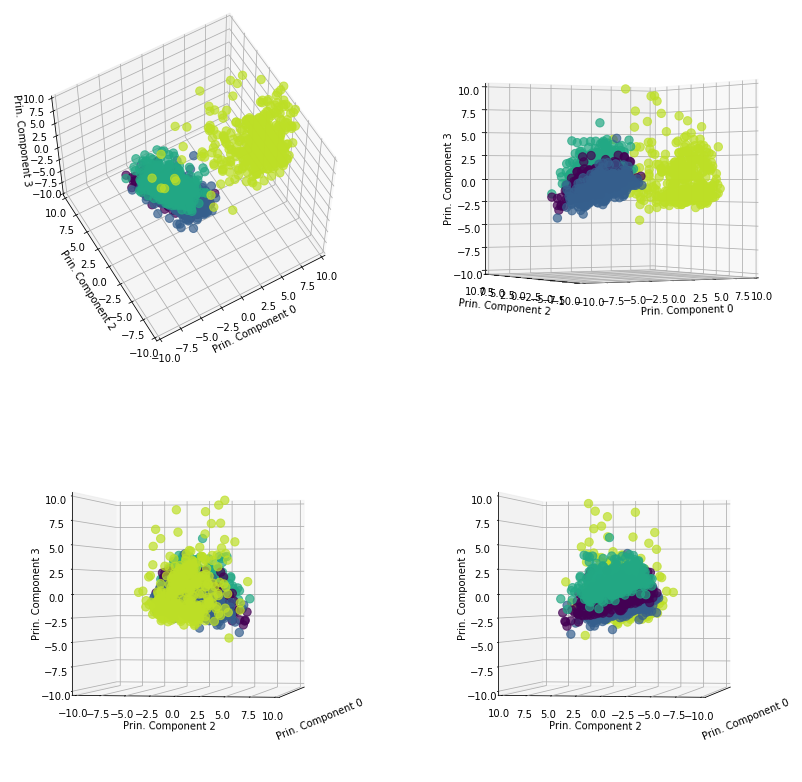

In [20]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Particle Type', lvals=labels, randcount=400, ylim=[-10, 10],
                              xlim=[-10, 10], zlim=[-10, 10], features=[0, 2, 3])

In [26]:
ncomp = 11
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Particle Type', labels, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Particle Type'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.8933888888888889
Run 1: 0.8965416666666667
Run 2: 0.8873194444444444
Run 3: 0.8911388888888889
Run 4: 0.8904444444444445
Run 5: 0.89175
Run 6: 0.8913333333333333
Run 7: 0.8950972222222222
Run 8: 0.8919583333333333
Run 9: 0.8897222222222222
Run 10: 0.9009583333333333
Run 11: 0.8945972222222223
Run 12: 0.8871388888888889
Run 13: 0.8914861111111111
Run 14: 0.8934166666666666
Run 15: 0.8965416666666667
Run 16: 0.8884722222222222
Run 17: 0.8910277777777778
Run 18: 0.8870833333333333
Run 19: 0.8887083333333333


In [27]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.906625 +/ 0.008510104288432668
0.8919062500000001 +/ 0.003497593073951968


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

def build_model(rawdata, feature, featvals, equal_sampling=True,
                    tsize=20, from_end=True, input_cols=6, model='KNN',
                    **kwargs):
    """Builds a K-nearest neighbor model using an input dataset.

    Parameters
    ----------
    rawdata : pandas.core.frames.DataFrame
        Raw dataset of n samples and p features.
    feature : string or int
        Feature in rawdata containing output values on which KNN
        model is to be based.
    featvals : string or int
        All values that feature can take.
    equal_sampling : bool
        If True, training dataset will contain an equal number
        of samples that take each value of featvals. If false,
        each sample in training dataset will be taken randomly
        from rawdata.
    tsize : int
        Size of training dataset. If equal_sampling is False,
        training dataset will be exactly this size. If True,
        training dataset will contain N x tsize where N is the
        number of unique values in featvals.
    n_neighbors : int
        Number of nearest neighbors to be used in KNN
        algorithm.
    from_end : int
        If True, in_cols will select features to be used as
        training data defined end of rawdata e.g.
        rawdata[:, -6:]. If False, input_cols will be read
        as a tuple e.g. rawdata[:, 10:15].
    input_col : int or tuple
        Defined in from_end above.

    Returns
    -------
    clf : sklearn.neighbors.classification.KNeighborsClassifier
        KNN model
    X : numpy.ndarray
        training input dataset used to create clf
    y : numpy.ndarray
        training output dataset used to create clf

    """

    defaults = {'n_neighbors': 5, 'NNsolver': 'lbfgs', 'NNalpha': 1e-5,
                'NNhidden_layer': (5, 2), 'NNrandom_state': 1,
                'n_estimators': 10}

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]
                                                   ), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature] == featval
                            ][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature] == featval
                                         ][feature].values[to_plot], axis=0)

    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]

    if model is 'KNN':
        clf = neighbors.KNeighborsClassifier(kwargs['n_neighbors'])
    elif model is 'MLP':
        clf = MLPClassifier(solver=kwargs['NNsolver'], alpha=kwargs['NNalpha'],
                            hidden_layer_sizes=kwargs['NNhidden_layer'],
                            random_state=kwargs['NNrandom_state'])
    else:
        clf = RandomForestClassifier(n_estimators=kwargs['n_estimators'])
    
    clf.fit(X, y)

    return clf, X, y

In [ ]:
subset

In [ ]:
fstats_new

In [ ]:
bitesize['Particle Type']